### This script extract actual speaking from the recordings. The output can be used by Gentle to do the forced alignment.
### The audio records only during the task running, no rest, no break, no dry run.
### Therefore, the length of the recording is about 15s/trial * 100 trials = 1500 seconds, which is the same as the playback.  Just cut it into segments with equal length (15 s).

### TODO: However, the audio captured was almost 1s shorter than the 15s/trial*100trials=15000 s; Is this 1s evenly distributed or only missed at the beginning or the ending of the recording?

### Therefor, one can't just evenly cut the recordings into 15s segments (some are longer, others are shorter than 15s). One have to identify the beginning of each trial, which corresponds to a 1s C6 note. Audio stimulus follows C6-4*beep-C5-4*beep-C5-4*beep. So, the begining of the C6 is the beginning of the trial.


It was caused by thees three pauses, with each of them missing aprox 0.33 second:

pause 1 before this: The theme was deemed to be taboo.(21)

pause 2 before this:A groovy beat to move your feet.(49)

pause 3 before this:The facts were addled by sleazy ads.(78)

In [5]:
import os
from scipy.io import wavfile
from dSPEECH.config import *
import glob
import matplotlib.pyplot as plt

In [6]:
sid=2
filename=data_dir+'raw/SEEG'+str(sid)+'_*/matlab/recording.wav'
filename=os.path.normpath(glob.glob(filename)[0])
sf,audio=wavfile.read(filename) # same length as in Matlab using psychwavread

/var/folders/dk/pz8_xy4j4ws187dv9gk541ch0000gn/T/ipykernel_29513/2391900586.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf,audio=wavfile.read(filename) # same length as in Matlab using psychwavread


In [7]:
length=audio.shape[0]
seg=length/100

In [8]:
short=length-1500*48000

In [9]:
short/sf # recordings miss 1 s; same as reading with librosa

-0.9900625

## Extract the trial beginning. Method 1: by simply checking the timing pattern. Some trials are mis-identified.

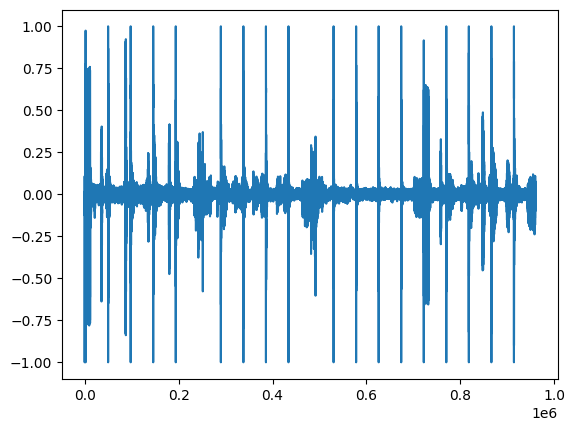

In [10]:
%matplotlib inline
plt.figure()
plt.plot(audio[:20*sf,0],label='emg1')
plt.show() # wierd is that there is a short high amplitude before every C6 note. This can be used to cut the audio into trials.

![](img/1.png)

There is also buzzling noise before each C5 and C6 note.

In [11]:
# the first high pulse after ~ 14.3s should be the beginning of each trial
offset=14.3
beginnings=[]
beginnings.append(0) # first trial
for i in range(1,99):
    point=int((i*15+offset)*sf)
    j=0
    while True:
        if audio[point+j,0] > 0.75:
            beginnings.append(point+j)
            break
        j=j+1

In [12]:
len(beginnings)

99

In [15]:
%matplotlib qt 
#inline
fig,ax=plt.subplots()
start=60
end=80
ax.plot(range(start*15*sf,end*15*sf),audio[start*15*sf:end*15*sf,0],label='emg1')
for i in range(start,end):
    ax.axvline(x=beginnings[i], color='green', linestyle='--')
plt.show()  # the green dashed lines (last two lines, 77th and 78th trial) is at the wrong place when start=60 and end=80.

![](img12.png)

In [38]:
offset=14.3
beginnings2=[]
beginnings2.append(0) # first trial
for i in range(1,77):
    point=int((i*15+offset)*sf)
    j=0
    while True:
        if audio[point+j,0] > 0.75:
            beginnings2.append(point+j)
            break
        j=j+1

# 77th
point=56100000
j=0
while True:
    if audio[point+j,0] > 0.75:
        beginnings2.append(point+j)
        break
    j=j+1


In [39]:
for i in range(78,98):
    point=beginnings2[77]+int(((i-77)*15+offset)*sf)  #int((i*15+offset)*sf)
    j=0
    while True:
        if audio[point+j,0] > 0.75:
            beginnings2.append(point+j)
            break
        j=j+1

In [40]:
len(beginnings2)

98

In [41]:
%matplotlib notebook
fig,ax=plt.subplots()
start=60
end=80
ax.plot(range(start*15*sf,end*15*sf),audio[start*15*sf:end*15*sf,0],label='emg1')
for i in range(start,end):
    ax.axvline(x=beginnings2[i], color='green', linestyle='--')
plt.show() 

<IPython.core.display.Javascript object>

## Extract the trial beginning. Method 2: by locate the 1046.50Hz C6 note
### However, it seems the 'C6' now is not 1046.5 anymore, it is 1048 now: below is the spectrogram from audacity(Analyze-->plot spectrum):

![](img13.png)


### option 1: lfilter in below is not stable: lfilter returns all nans.

In [5]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [6]:
fs = 48000
lowcut = 58
highcut = 62
y = butter_bandpass_filter(audio, lowcut, highcut, fs, order=6)

In [ ]:
%matplotlib notebook
plt.plot(np.arange(y.shape[0]),y)
plt.show()

### option 2: use the MNE method

In [11]:
ch_type=['eeg','eeg']
ch_name=['eeg','eeg']
info = mne.create_info(ch_names=ch_name, sfreq=48000, ch_types=ch_type)
raw = mne.io.RawArray(audio.transpose(), info)

In [12]:
ff=raw.filter(1047,1049) # 'C6' in the recording is now 1048 Hz.

In [20]:
ff.plot() # 'c6's were isolated, as showed below, and length of ff is the same as audio.  

 (list of C6s)  
 
![](img14.png)  

An example C6:

![](img15.png)

In [13]:
beep=ff.get_data()  # (2, 71952477)

In [14]:
beginnings3=[]
i=0
while i < beep.shape[1]:
    if beep[0,i]>0.5:
        beginnings3.append(i)
        i=int(i+5*sf)
    i=i+1

In [25]:
# plot the whole data directly. Slow, but it works.
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(audio[:,0])
for i in range(len(beginnings3)):
    ax.axvline(x=beginnings3[i], color='green', linestyle='--')
plt.show() # looking good. All trial beginnings have been identified.

<IPython.core.display.Javascript object>

In [7]:
len(beginnings3)

100

In [15]:
# check each segmentation length, make sure it is 15s.
lens=[]
for i in range(len(beginnings3)-1):
    tmp=(beginnings3[i+1]-beginnings3[i])/48000-15
    lens.append(tmp)

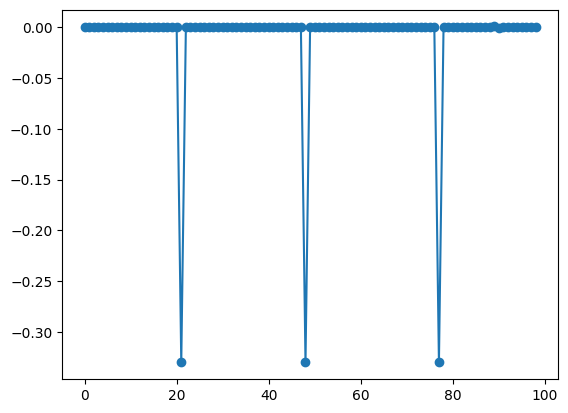

In [16]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(lens,marker='o')
plt.show() # There are three trials which miss around 300ms in the recordings. Next step: check if there are also three trials with shorter period. They are trials just following the 3 pauses.

In [21]:
lens[77] #21,48,77

-0.33004166666666634

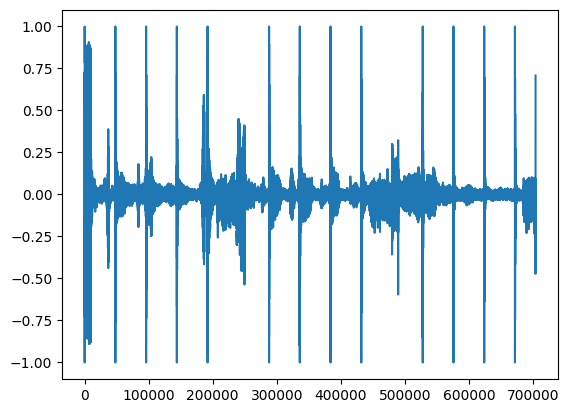

In [35]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(audio[beginnings3[21]:beginnings3[22],0])
plt.show() # It is clear that this missing of 300ms happens to the end of the 15s recording. 

This is plots of trials 21,48 and 77. So the missing data SHOULD not be an issue since it only affect the imagery part.

![](img/2.png)

 ### Use the beginnings marker to segment the audio. Save the audio: only keep the actual speaking part, no listening or imaging part.

In [8]:
for i in range(100):
    filename=data_dir+'processed/SEEG'+str(sid)+'/speaking_clips/'+str(i)+'.wav'
    if i==99:
        start=beginnings3[i]
        clip=audio[start+5*sf:start+10*sf:,:]
    else:
        start=beginnings3[i]
        end=beginnings3[i+1]
        clip=audio[start+5*sf:start+10*sf,:]
    wavfile.write(filename, sf, clip)

In [3]:
# check the clip length
lens=[]
sid=2
for i in range(100):
    filename=data_dir+'processed/SEEG'+str(sid)+'/speaking_clips/'+str(i)+'.wav'
    sf,audio=wavfile.read(filename)
    lens.append(audio.shape[0]/sf)

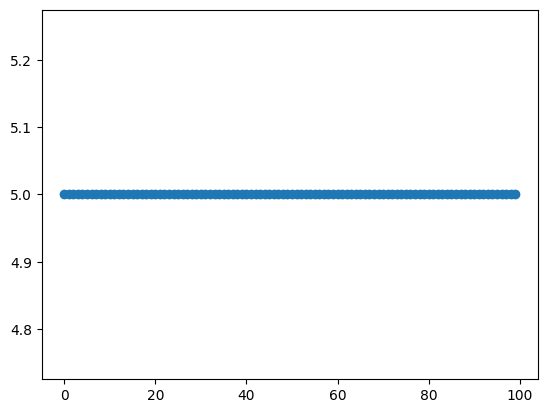

In [4]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(lens,marker='o')
plt.show() 